### Setting up the Frameworks

In [1]:
import tensorflow, keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

from keras import backend as K

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


TensorFlow version: 1.12.0
Keras version: 2.2.4


### Preparing the Data

In [2]:
from keras.preprocessing.image import ImageDataGenerator

data_folder = 'resized_images'
img_size = (128, 128)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classes = sorted(train_generator.class_indices.keys())
print("class names: ", classes)

Getting Data...
Preparing training dataset...
Found 1491 images belonging to 12 classes.
Preparing validation dataset...
Found 631 images belonging to 12 classes.
class names:  ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']


### Defining the CNN
Now we're ready to train our model. This involves defining the layers for our CNN, and compiling them for multi-class classification.

In [3]:
# Define a CNN classifier network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(24, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution, max pooling, and dropout layer
model.add(Conv2D(48, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# We can add as many layers as we think necessary - here we'll add another convolution, max pooling, and dropout layer
model.add(Conv2D(96, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.5))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 123, 24)      2616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 48)        41520     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 96)        165984    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 96)        0         
__________

### Training the Model


In [4]:
num_epochs = 30
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/30
49/49 [==============================] - 19s 383ms/step - loss: 1.5283 - acc: 0.5068 - val_loss: 0.7662 - val_acc: 0.7571
Epoch 2/30
49/49 [==============================] - 2s 43ms/step - loss: 0.6230 - acc: 0.7917 - val_loss: 0.6175 - val_acc: 0.7854
Epoch 3/30
49/49 [==============================] - 2s 39ms/step - loss: 0.4552 - acc: 0.8525 - val_loss: 0.5113 - val_acc: 0.8286
Epoch 4/30
49/49 [==============================] - 2s 39ms/step - loss: 0.3145 - acc: 0.8866 - val_loss: 0.4406 - val_acc: 0.8586
Epoch 5/30
49/49 [==============================] - 2s 39ms/step - loss: 0.2134 - acc: 0.9205 - val_loss: 0.3780 - val_acc: 0.8852
Epoch 6/30
49/49 [==============================] - 2s 39ms/step - loss: 0.2060 - acc: 0.9235 - val_loss: 0.4048 - val_acc: 0.8652
Epoch 7/30
49/49 [==============================] - 2s 39ms/step - loss: 0.1910 - acc: 0.9312 - val_loss: 0.3352 - val_acc: 0.8835
Epoch 8/30
49/49 [==============================] - 2s 39ms/step - loss: 0.1381 -

### View the Loss History

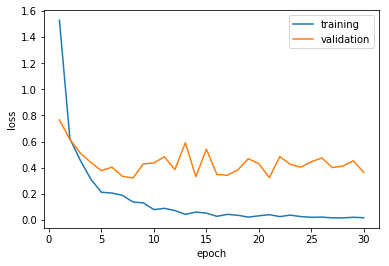

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Save the Model


In [6]:
from keras.models import load_model

modelFileName = 'gear-classifier.h5'

model.save(modelFileName) # saves the trained model
print("Model saved.")

del model  # deletes the existing model variable

Model saved.


### Use the Model with New Data
Now that we've trained and evaluated our model, we can use it to predict classes for new images.

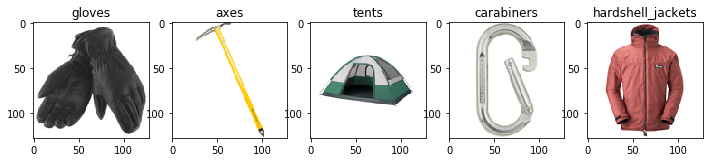

In [8]:
# Helper function to make image square
def reshape_image(img, size): 
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return np.array(newimg)

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    imgfeatures = image_array.astype('float32')
    imgfeatures /= 255
    
    # These are the classes our model can predict
    classnames = ['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']
    
    # Predict the class of each input image
    predictions = classifier.predict(imgfeatures)
    
    predicted_classes = []
    for prediction in predictions:
        class_idx = np.argmax(prediction)
        predicted_classes.append(classnames[int(class_idx)])
    return predicted_classes

# Predict class for new data
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

image_urls = []
image_urls.append('https://upload.wikimedia.org/wikipedia/commons/8/82/Skiglove.png')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (128,128)

img_array = []

for url_idx in range(len(image_urls)):
    # Get the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = reshape_image(img, size)
    img_array.append(img)
    
# load the saved model
model = load_model(modelFileName) 
    
predicted_classes = predict_image(model, np.array(img_array))

fig = plt.figure(figsize=(12, 8))
idx = 0
for predicted_class in predicted_classes:
    a=fig.add_subplot(1,len(image_urls),idx+1)
    img = img_array[idx]
    imgplot = plt.imshow(img)
    a.set_title(predicted_class)
    idx += 1
